---

# Practical Machine Learning with Python
# Chapter 3: Classification

## Guillermo Avendaño-Franco 

### HPC Summer Workshop 2019

---

This notebook is basically adapted from one of the notebooks from Aurelien Geron author of Hands-on Machine Learning with Scikit-learn and TensorFlow. The notebooks are located here <https://github.com/ageron/handson-ml>

The changes are basically in adapting the content lenght to the constrains of the Workshop.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn

# Where we are in the map?

<img src="fig/ml_map.png" width="700" height="200" title="Precision vs Recall" alt="Precision vs Recall"></a>

# Classification 

Classification and Regression are the foundations of many of the algorithms for Machine Learning, particular supervised learning. In this case the problem is to identify to which class or category new data belongs once we have trained the model with a set of data for which we know the answers.

In machine learning and statistics, classification is the problem of identifying to which of a set of categories (sub-populations) a new observation belongs, on the basis of a training set of data containing observations (or instances) whose category membership is known.

The following exercise provide a nice introduction to many of the relevant concepts in classification, some of them still valid when move into the prediction of continuum values in regression problems.

# MNIST database

The MNIST database of handwritten digits, available from this page, the original data downloaded from OpenML contains 70000 images and the known values, the corresponding digit for each image. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. 

Many methods have been tested with this training set and test set. For more information about the original datasets from NIST see [Yann LeCun Website](http://yann.lecun.com/exdb/mnist/)

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, data_home=".", cache=True)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

Each image is a vector with 784 components corresponding to a matrix 28 x 28

In [5]:
28 * 28

784

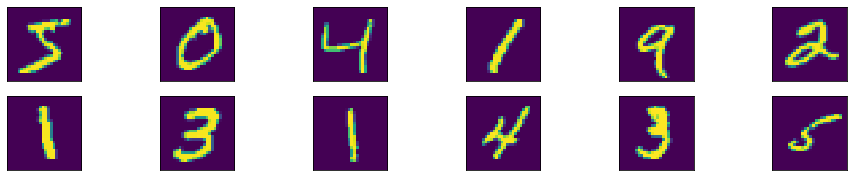

In [6]:
# Number of Rows
rgrid=2
# Number of Columns
cgrid=6
fig, axes = plt.subplots(rgrid,cgrid, figsize=(16,3))
for i in range(rgrid):
    for j in range(cgrid):
        #print(i,j,cgrid*i+j)
        axes[i,j].imshow(X[cgrid*i+j].reshape(28,28))
        axes[i,j].xaxis.set_ticks_position('none')
        axes[i,j].yaxis.set_ticks_position('none')
        axes[i,j].set_yticklabels([])
        axes[i,j].set_xticklabels([])

In [7]:
y[:12].reshape(2,6)

array([['5', '0', '4', '1', '9', '2'],
       ['1', '3', '1', '4', '3', '5']], dtype=object)

In [8]:
y = y.astype(np.uint8)

In [9]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [10]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

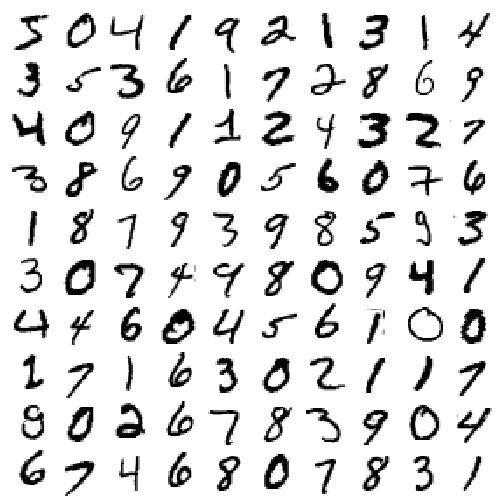

In [11]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)

In [12]:
y[0]

5

In [13]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Binary classifier

Later we will attack the problem of classify all the ten digits. For now lets focus on a more modest problem of classify if a given number is 5 or not.

In [14]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

**Note**: some hyperparameters will have a different defaut value in future versions of Scikit-Learn, such as `max_iter` and `tol`. To be future-proof, we explicitly set these hyperparameters to their future default values. For simplicity, this is not shown in the book.

There are several classifiers implemented in Scikit-Learn, the Stochastic gradient descent (SGD) `SGDClassifier` is a simple yet very efficient approach to fit linear models. It is particularly useful when the number of samples (and the number of features) is very large. Right now the point is to get a black box that do classification for us.

In [15]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [16]:
sgd_clf.predict(X_train[:12])

array([ True, False, False, False, False, False, False, False, False,
       False, False,  True])

In [17]:
y_train[:12]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5], dtype=uint8)

We can see that indeed the classifier seems to work fine. How to quantify that?

## Accuracy

The first measure will be accuracy, the total number of right answers versus the total number of misses

\begin{equation}
accuracy = \frac{\text{Total number of right answers}}{\text{Total number of cases}}
\end{equation}

We can do that for several subsets of the train set, in what is called **cross validation**

In [18]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

However, we can create a new classifier that always answers negatively no matter what vector is presented.

In [19]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [20]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

We got 90% accuracy, which is consistent with a set of many cases where each digit is represented with the same frequency than any other.

## Confusion matrix

A better way of looking at the performance of a classifier is via the confusion matrix. A matrix that for each instace can be divided into 4 sets

 * **True positives** Images that are 5s and were identified as 5s
 * **True negatives** Images that are NOT 5s and were identified as NOT 5s
 * **False positives** Images that are NOT 5s but were identified as 5s
 * **False negatives** Images that are 5s but were identified as NOT 5s

In [21]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_train_pred = sgd_clf.predict(X_train)

In [22]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[52316,  2263],
       [  601,  4820]])

A perfect confusion matrix will look like this:

In [23]:
y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

### Precision, Recall and F1

<img src="fig/Precision_Recall.png" width="700" height="200" title="Precision vs Recall" alt="Precision vs Recall"></a>

Instead of using the **accuracy** a better metric could be use the precision and recall as defined by:

\begin{equation}
precision = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}
\end{equation}

---

\begin{equation}
recall = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
\end{equation}

Finally there is one metric that measures the balance between precision and recall

\begin{equation}
F_1 = \frac{\text{precision} \times \text{recall}}{\text{precision} + \text{recall}}
\end{equation}


In [24]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.6805026118876183

In [25]:
# TP = 4820
# FP = 2263
4820 / (4820 + 2263)

0.6805026118876183

In [26]:
recall_score(y_train_5, y_train_pred)

0.8891348459693783

In [27]:
# TP = 4820
# FN = 601
4820 / (4820 + 601)

0.8891348459693783

In [28]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7709532949456175

In [29]:
4820 / (4820 + (601 + 2263) / 2)

0.7709532949456174

### Decision Function

Scikit-learn provides a function to show the value that the SGD assign to each set of inputs. See for example the first 12

In [30]:
y_scores = sgd_clf.decision_function(X_train[:12])
y_scores

array([  2164.22030239,  -5897.37359354, -13489.14805779,  -4623.84515943,
        -6873.05248453,  -3908.27576291,  -4851.9422397 ,  -4988.52407755,
        -2226.78132866,  -4081.33692831,  -5711.47789687,   4742.52813158])

Notice that images indentified with 5 received positive score and other numbers received negative scores.

In [31]:
y_train[:12]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5], dtype=uint8)

## Changing the threshold 

one interesting observation is to notice that if by any means we could change the threshold of acceptance for considering a image a 5 we increase the precision (by reducing FP) but at expenses of also reducing the recall (by also increasing the FN). In summary precision and recall are two conflicting quantities.

In [32]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [33]:
y_some_digit_pred

array([ True, False, False, False, False, False, False, False, False,
       False, False,  True])

In [34]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False, False, False, False, False, False, False, False, False,
       False, False, False])

In [35]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [36]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

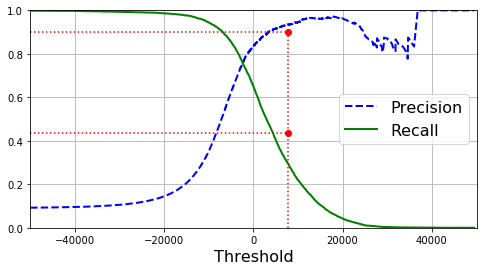

In [37]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown

plt.figure(figsize=(8, 4))                      # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([7813, 7813], [0., 0.9], "r:")         # Not shown
plt.plot([-50000, 7813], [0.9, 0.9], "r:")      # Not shown
plt.plot([-50000, 7813], [0.4368, 0.4368], "r:")# Not shown
plt.plot([7813], [0.9], "ro")                   # Not shown
plt.plot([7813], [0.4368], "ro")                # Not shown


In [38]:
(y_train_pred == (y_scores > 0)).all()

False

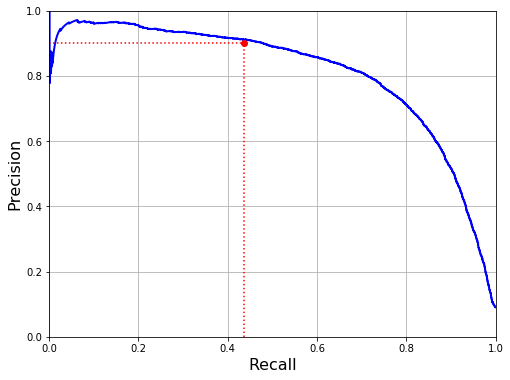

In [39]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.4368, 0.4368], [0., 0.9], "r:")
plt.plot([0.0, 0.4368], [0.9, 0.9], "r:")
plt.plot([0.4368], [0.9], "ro");

In [40]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [41]:
threshold_90_precision

3370.0194991439594

In [42]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [43]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [44]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

# ROC curves

The Receiver Operating Characteristic (ROC) is a plot of recall (also known as *True Positive Rate*) against False Positive Rate (FPR) that is one minus the True Negative Rate (TNR) (Negative instances correctly indentified as negative)

 * FPR = 1 - TNR = 1 - specificity
 * TPR = Recall = sensitivity

In [45]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

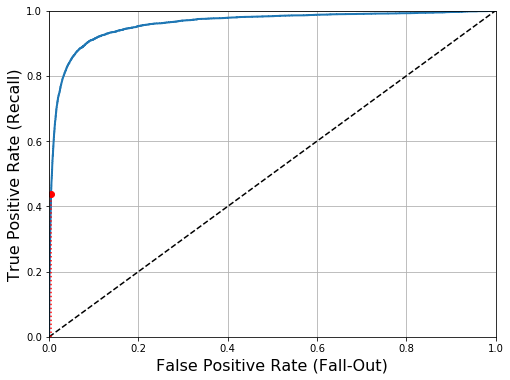

In [46]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown

In [47]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

**Note**: we set `n_estimators=100` to be future-proof since this will be the default value in Scikit-Learn 0.22.

In [48]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [49]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

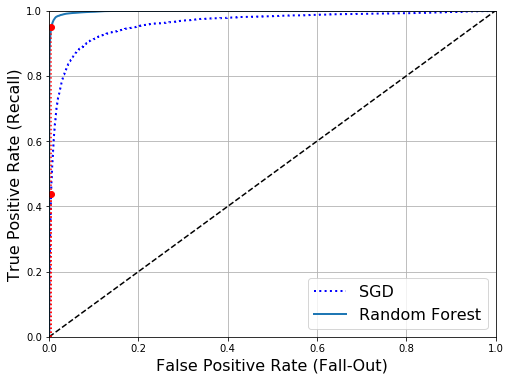

In [50]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:")
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")
plt.plot([4.837e-3], [0.4368], "ro")
plt.plot([4.837e-3, 4.837e-3], [0., 0.9487], "r:")
plt.plot([4.837e-3], [0.9487], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)

In [51]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [52]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [53]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

# Multiclass classification

The case until now was a binary classifier, but the MNIST is actually a multiclass classification problem.
There are several Multiclass classifiers in Scikit-learn

In [54]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train, not y_train_5
svm_clf.predict(X_train[:12])

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5], dtype=uint8)

In [55]:
y_train[:12]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5], dtype=uint8)

In [56]:
scores_for_5 = svm_clf.decision_function(X_train[:1])
scores_for_5

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [57]:
np.argmax(scores_for_5)

5

In [58]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [59]:
svm_clf.classes_[5]

5

In [60]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict(X_train[:12])

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5], dtype=uint8)

In [61]:
len(ovr_clf.estimators_)

10

In [62]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [63]:
sgd_clf.predict(X_train[:12])

array([3, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5], dtype=uint8)

In [64]:
sgd_clf.decision_function(X_train[:1])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [65]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87082583, 0.87089354, 0.88628294])

In [66]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled[:1000], y_train[:1000], cv=3, scoring="accuracy")

array([0.85416667, 0.82582583, 0.81268882])

In [67]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled[:1000], 
                                 y_train[:1000], cv=3)
conf_mx = confusion_matrix(y_train[:1000], y_train_pred[:1000])
conf_mx

array([[ 90,   0,   1,   0,   0,   6,   0,   0,   0,   0],
       [  1, 106,   1,   0,   0,   4,   1,   0,   2,   1],
       [  2,   8,  78,   1,   2,   1,   2,   1,   3,   1],
       [  0,   1,   6,  75,   0,   5,   1,   1,   1,   3],
       [  0,   1,   0,   1,  92,   3,   1,   0,   2,   5],
       [  1,   2,   2,   5,   4,  68,   1,   0,   6,   3],
       [  3,   1,   2,   0,   3,   4,  81,   0,   0,   0],
       [  0,   2,   2,   0,   2,   0,   0, 102,   0,   9],
       [  1,   3,   1,   0,   1,   5,   4,   2,  69,   1],
       [  4,   0,   1,   0,   9,   1,   0,  14,   1,  70]])

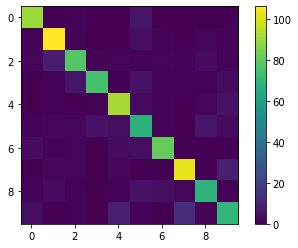

In [68]:
plt.imshow(conf_mx)
plt.colorbar();

In [69]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

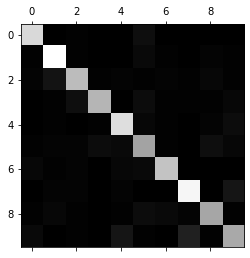

In [70]:
plt.matshow(conf_mx, cmap=plt.cm.gray)

In [71]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

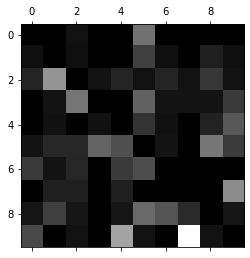

In [72]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

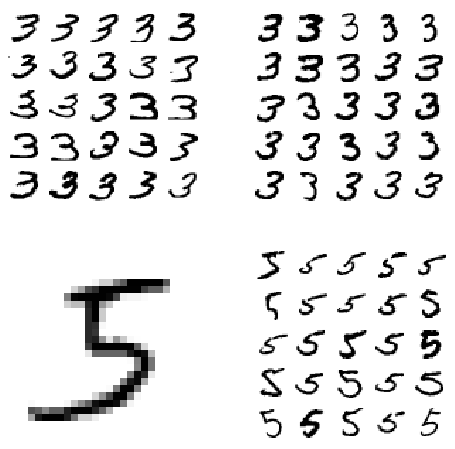

In [73]:
y_train_pred = sgd_clf.predict(X_train_scaled)

cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

# Multilabel classification

In [74]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [75]:
knn_clf.predict(X_train[:4])

array([[False,  True],
       [False, False],
       [False, False],
       [False,  True]])

**Warning**: the following cell may take a very long time (possibly hours depending on your hardware).

In [76]:
y_train_knn_pred = knn_clf.predict(X_train[:100])
f1_score(y_multilabel[:100], y_train_knn_pred, average="macro")

0.9862775751259336

# Multioutput classification

In [77]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

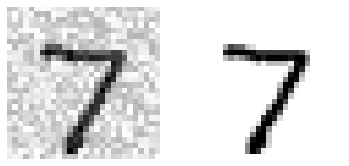

In [78]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])

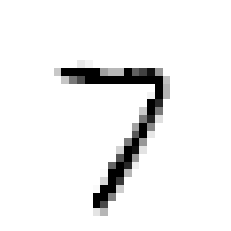

In [79]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)